In [55]:
##################################################################
# This Script:
#    - 
#    -
#    -

##################################################################
import iris
import os
import glob as sir_globington_the_file_gatherer
import datetime as datetime
import iris.coord_categorisation as cat
import sys
import time
import multiprocessing as mp
import iris.plot as iplt

# Set up path to root directory
root_fp = "/nfs/a319/gy17m2a/PhD/"
os.chdir(root_fp)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from warnings import simplefilter
warnings.filterwarnings("ignore", category =UserWarning,)

# Create path to files containing functions
sys.path.insert(0, root_fp + 'Scripts/GlobalFunctions')
from Spatial_plotting_functions import *
from Spatial_geometry_functions import *

trim_to_leeds = False

##################################################################
# Load necessary spatial data
##################################################################
# This is a square area surrounding Leeds
uk_gdf = create_uk_outline({'init' :'epsg:3857'})
gb_gdf = create_gb_outline({'init' :'epsg:3857'})
##################################################################

# Constraint to only load 
in_jja=iris.Constraint(time=lambda cell: 6 <= cell.point.month <= 8)

yrs_range = "2002_2020"
yrs= range(2002,2020)
resolution = '2.2km_regridded_12km' #2.2km, 12km, 2.2km_regridded_12km

### Establish the ensemble members
ems = ['05']#'06', '07', '08', '09', '10', '11', '12', '13', '15']

for em in ems:

    ddir = f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{yrs_range}/{em}/"

    print(em, resolution, trim_to_leeds)
    for yr in yrs:
        print(em, yr)

        # ### Get a list of filenames for this ensemble member, for just JJA
        if resolution == '2.2km':
            general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_{yr}*'
        elif resolution == '12km':
              general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/{yrs_range}/pr_rcp85_land-rcm_uk_12km_{em}_day_*'
        elif resolution == '2.2km_regridded_12km':
            general_filename = f'/nfs/a319/gy17m2a/PhD/datadir/UKCP18_hourly/{resolution}/{em}/NearestNeighbour/{yrs_range}/rg_pr_rcp85_land-cpm_uk_2.2km_{em}_1hr_*'

        filenames = []
        for filename in sir_globington_the_file_gatherer.glob(general_filename):
            filenames.append(filename)
        print(f"loading {len(filenames)} files")

        # ### Load in the data
        monthly_cubes_list = iris.load(filenames, in_jja)
        print(len(monthly_cubes_list))
        
        for cube in monthly_cubes_list:
             for attr in ['creation_date', 'tracking_id', 'history', 'Conventions']:
                    if attr in cube.attributes:
                        del cube.attributes[attr]

        # ### Concatenate cubes into one
        model_cube = monthly_cubes_list.concatenate_cube()      

        ### Remove ensemble member dimension
        model_cube = model_cube[0,:,:,:]
        
#         # ### Trim to UK
#         if resolution  == '2.2km':
#             model_cube = trim_to_bbox_of_region_regriddedobs(model_cube, gb_gdf)
#         else:
#             model_cube = trim_to_bbox_of_region_obs(model_cube, gb_gdf)
        
#         # ### Get the mask
#         print("getting mask")
#         if resolution =='2.2km':
#             gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_2.2km_GB_Mask.npy")
#         else:
#             gb_mask = np.load("/nfs/a319/gy17m2a/PhD/datadir/UKCP18_12km_GB_Mask.npy")
#         masked_cube_data = model_cube * gb_mask[np.newaxis, :, :]

#         # APPLY THE MASK
#         reshaped_mask = np.tile(gb_mask, (model_cube.shape[0], 1, 1))
#         reshaped_mask = reshaped_mask.astype(int)
#         reversed_array = ~reshaped_mask.astype(bool)

#         # Mask the cube
#         masked_cube = iris.util.mask_cube(model_cube, reversed_array)

#         # ### Check the mask
#         # iplt.contourf(masked_cube[10])
#         # plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

#         # Save
#         iris.save(masked_cube, ddir + f'{yr}_maskedcube.nc')      
        
#         # Check the plotting
#         # iplt.contourf(masked_cube[10])
#         # plt.gca().coastlines(resolution='10m', color='black', linewidth=0.5);

#         # Get rid of negative values
#         compressed = masked_cube.data.compressed()
#         compressed.shape[0]

#         ########
#         # Get the times
#         ########
#         # Step 2: Get the indices of the non-masked values in the original data
#         non_masked_indices = np.where(~masked_cube.data.mask)

#         # Step 3: Extract corresponding time values
#         # time_values = masked_cube.coord('time').points[non_masked_indices[0]]

#         # Save to file
#         # np.save(ddir + f'timevalues_{yr}.npy', time_values) 
#         np.save(ddir + f'compressed_{yr}.npy', compressed) 

# time_values = masked_cube.coord('yyyymmddhh').points[non_masked_indices[0]]
# np.save(f"ProcessedData/TimeSeries/UKCP18_hourly/{resolution}/{yrs_range}/timevalues.npy", time_values)

05 2.2km_regridded_12km False
05 2002
loading 57 files
57
05 2003
loading 57 files
57
05 2004
loading 57 files
57
05 2005
loading 57 files
57
05 2006
loading 57 files
57
05 2007
loading 57 files
57
05 2008
loading 57 files
57
05 2009
loading 57 files
57
05 2010
loading 57 files


KeyboardInterrupt: 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
bins = 8
bins_i_want = [0.1, 3, 7, 10,15, 21, 35,45, 62]
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

data = np.load('/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/2.2km_regridded_12km/1980_2001/15/compressed_2000.npy')
data = data[~np.isnan(data)]
data = data[data >= 0.1]
count, bins_count = np.histogram(data, bins=bins_i_want)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
reverse_cdf = 1-cdf
plt.plot(bins_count[1:], reverse_cdf, label="Model")


data = np.load('/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/2000_compressed.npy')
data = data[~np.isnan(data)]
data = data[data >= 0.1]
count, bins_count = np.histogram(data, bins=bins_i_want)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
reverse_cdf = 1-cdf
plt.plot(bins_count[1:], reverse_cdf, label="Obs")


plt.legend()
plt.yscale('log')
plt.show()

In [64]:
data = model_cube.data
data = data[~np.isnan(data)]
data = data[data >= 0.1]
np.nanmean(data)

1.0713842

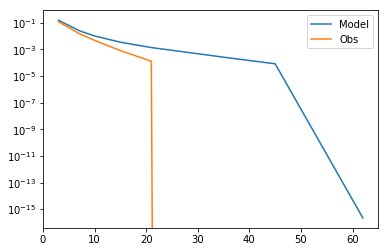

In [100]:
bins_i_want  =  [0.5, 3, 7, 10,15, 21, 35,45, 62]
data = data[~np.isnan(data)]
data = data[data >= 0.1]
count, bins_count = np.histogram(data, bins=bins_i_want)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
reverse_cdf = 1-cdf
plt.plot(bins_count[1:], reverse_cdf, label="Model")

obs_data = np.load('/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/2000_compressed.npy')
obs_data = obs_data[~np.isnan(obs_data)]
obs_data = obs_data[obs_data >= 0.1]
count, bins_count = np.histogram(obs_data, bins=bins_i_want)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
reverse_cdf = 1-cdf
plt.plot(bins_count[1:], reverse_cdf, label="Obs")

plt.legend()
plt.yscale('log')
plt.show()

In [108]:
obs_data = np.load('/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/2000_compressed.npy')
obs_data = obs_data[~np.isnan(obs_data)]
obs_data = obs_data[obs_data >= 0.1]
len(obs_data)

338078

In [116]:
bins_i_want  =  [0.05, 3, 7, 10,15, 21, 35,45, 62, 78]
count, bins_count = np.histogram(obs_data, bins=bins_i_want)
count.sum()

338078

In [118]:
data = data[~np.isnan(data)]
data = data[data >= 0.1]
count, bins_count = np.histogram(data, bins=bins_i_want)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf, label="Model")
count.sum()

33144134

In [119]:
len(data)

33144213

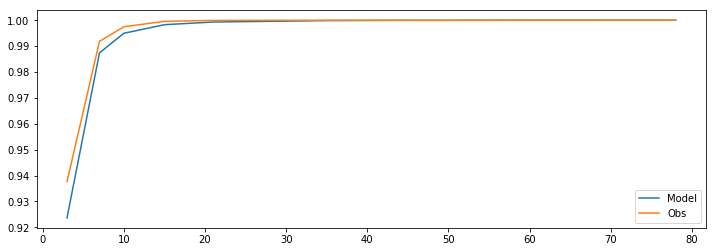

In [117]:
import matplotlib.ticker as ticker
bins_i_want  =  [0.05, 3, 7, 10,15, 21, 35,45, 62, 78]

fig, ax = plt.subplots(figsize=(12,4))

data = data[~np.isnan(data)]
data = data[data >= 0.1]
count, bins_count = np.histogram(data, bins=bins_i_want)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf, label="Model")

obs_data = np.load('/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/2000_compressed.npy')
obs_data = obs_data[~np.isnan(obs_data)]
obs_data = obs_data[obs_data >= 0.1]
count, bins_count = np.histogram(obs_data, bins=bins_i_want)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
ax.plot(bins_count[1:], cdf, label="Obs")

ax.legend()
# ax.set_yscale('log')

ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


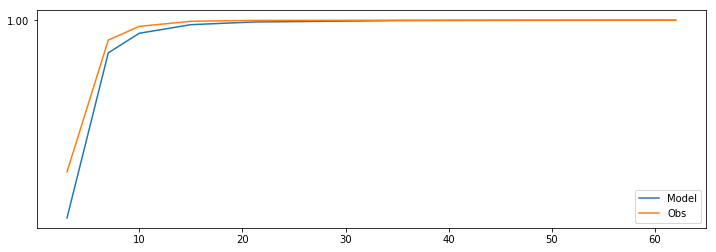

In [98]:
import matplotlib.ticker as ticker
bins_i_want  =  [0.5, 3, 7, 10,15, 21, 35,45, 62]

fig, ax = plt.subplots(figsize=(12,4))

data = data[~np.isnan(data)]
data = data[data >= 0.1]
count, bins_count = np.histogram(data, bins=bins_i_want)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
reverse_cdf = 1-cdf
ax.plot(bins_count[1:], cdf, label="Model")

obs_data = np.load('/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/2000_compressed.npy')
obs_data = obs_data[~np.isnan(obs_data)]
obs_data = obs_data[obs_data >= 0.1]
count, bins_count = np.histogram(obs_data, bins=bins_i_want)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
reverse_cdf = 1-cdf
ax.plot(bins_count[1:], cdf, label="Obs")

ax.legend()
# ax.set_yscale('log')

ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=15))
# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

## Testing starts here

### Check if one year of data in CEH-GEAR and one ensemble member has a similar amount of data
Model data is much longer  
Model data doesnt have any NANs in it  
Obs data only has a few  

In [166]:
# Model data for one ensemble member, in one year
model_data= np.load('/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/UKCP18_hourly/2.2km_regridded_12km/1980_2001/15/compressed_2000.npy')
print(len(model_data))
model_data = model_data[~np.isnan(model_data)]
print(len(model_data))
model_data = model_data[model_data >= 0.1]
print(len(model_data))
print(np.nanmax(model_data))
print(np.nanmean(model_data))
print(np.nanmin(model_data))

3473280
3473280
275523
91.722946
1.437498
0.10000127


In [167]:
obs_data = np.load('/nfs/a319/gy17m2a/PhD/ProcessedData/TimeSeries/CEH-GEAR/12km/NearestNeighbour/2000_compressed.npy')
print(len(obs_data))
obs_data = obs_data[~np.isnan(obs_data)]
print(len(obs_data))
obs_data = obs_data[obs_data >= 0.1]
print(len(obs_data))
print(np.nanmax(obs_data))
print(np.nanmean(obs_data))
print(np.nanmin(obs_data))

3550464
3543840
338078
32.2
0.9537066
0.1


### Why does CEH-GEAR still have nans in it after processsing

In [175]:
obs_count.sum()
model_count.sum()

275517
338078

275517

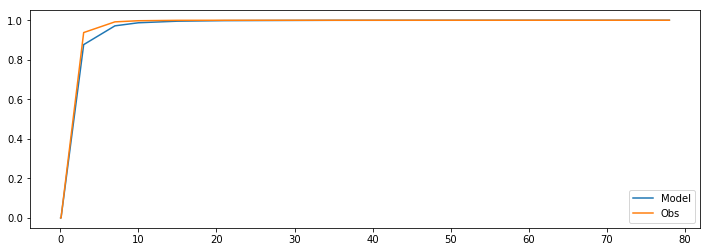

In [197]:
import matplotlib.ticker as ticker
bins_i_want  =  [0, 0.05, 0.1, 3, 7, 10,15, 21, 35,45, 62, 78]

fig, ax = plt.subplots(figsize=(12,4))
# model_data =model_data[~np.isnan(model_data)]
model_data = model_data[model_data >= 0.1]
model_count, bins_count = np.histogram(model_data, bins=bins_i_want)
model_pdf = model_count / sum(model_count)
model_cdf = np.cumsum(model_pdf)
ax.plot(bins_count[1:], model_cdf, label="Model")

# obs_data = obs_data[~np.isnan(obs_data)]
obs_data = obs_data[obs_data >= 0.1]
obs_count, bins_count = np.histogram(obs_data, bins=bins_i_want)
obs_pdf = obs_count / sum(obs_count)
obs_cdf = np.cumsum(obs_pdf)
ax.plot(bins_count[1:], obs_cdf, label="Obs")

ax.legend()
# ax.set_yscale('log')

ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
# ax.get_yaxis().set_major_formatter(
#     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))


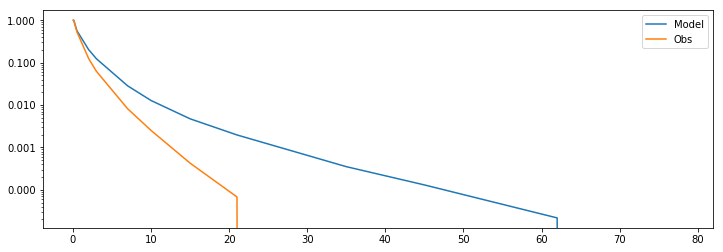

In [196]:
import matplotlib.ticker as ticker
bins_i_want  =  [0, 0.05, 0.1, 0.5,2, 3, 7, 10,15, 21, 35,45, 62, 78]

fig, ax = plt.subplots(figsize=(12,4))
# model_data =model_data[~np.isnan(model_data)]
model_data = model_data[model_data >= 0.1]
model_count, bins_count = np.histogram(model_data, bins=bins_i_want)
model_pdf = model_count / sum(model_count)
model_cdf = np.cumsum(model_pdf)
model_reversed_cdf = 1 - model_cdf
ax.plot(bins_count[1:], model_reversed_cdf, label="Model")

# obs_data = obs_data[~np.isnan(obs_data)]
obs_data = obs_data[obs_data >= 0.1]
obs_count, bins_count = np.histogram(obs_data, bins=bins_i_want)
obs_pdf = obs_count / sum(obs_count)
obs_cdf = np.cumsum(obs_pdf)
obs_reversed_cdf = 1 - obs_cdf
ax.plot(bins_count[1:], obs_reversed_cdf, label="Obs")

ax.legend()
ax.set_yscale('log')

# ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=False))
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(x, '.3f')))